In [6]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.io


# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")


# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


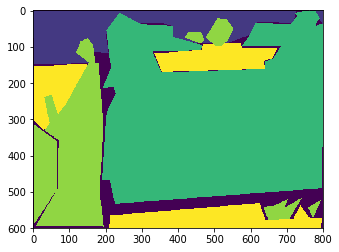

In [7]:
image1 = skimage.io.imread("./train/labels/exp_000001.png")
image2 = skimage.io.imread("./train/images/exp_000001.png")
plt.imshow(image1)


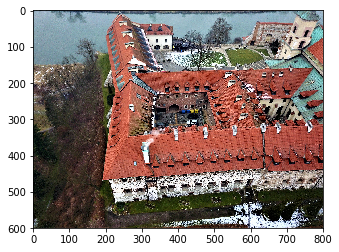

In [8]:
plt.imshow(image2)

In [21]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    
    BACKBONE = "resnet50"
    # Give the configuration a recognizable name
    NAME = "my-config"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 6 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 16

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()




Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [22]:
class TrainDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
   
    
    image_info = np.array([])
    num_classes = 7
    source_class_ids = {"shapes": [1,2,3,4,5,6]}
    
    def __init__(self,type):
        if(type=="train"):
            self.TRAIN_IMAGE_DIR = "./train/images"
            self.TRAIN_LABEL_DIR = "./train/labels"
            
        elif(type=="eval"):
            self.TRAIN_IMAGE_DIR = "./val/images"
            self.TRAIN_LABEL_DIR = "./val/labels"
        else: raise ValueError("dataset type error!")
        
        self.file_names = next(os.walk(self.TRAIN_IMAGE_DIR))[2][:50]
        self.image_num = len(self.file_names)
        self._image_ids = np.array(range(self.image_num))
        self.file_labels = next(os.walk(self.TRAIN_LABEL_DIR))[2][:50]
    
    class_list = [
        "background",
        "water",
        "sky",
        "road",
        "building",
        "vegetation",
        "ground"
    ]
    
    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        #self.add_class("shapes", 0, "background")
        self.add_class("shapes", 1, "water")
        self.add_class("shapes", 2, "sky")
        self.add_class("shapes", 3, "road")
        self.add_class("shapes", 4, "building")
        self.add_class("shapes", 5, "vegetation")
        self.add_class("shapes", 6, "ground")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            print (bg_color)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)
    
        
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        image_path = os.path.join(self.TRAIN_IMAGE_DIR,self.file_names[image_id])
        image = np.array(skimage.io.imread(image_path))
        info = {'width': 600, 
                'id': image_id, 
                'shapes': [
                    ('triangle', (194, 20, 160), (84, 38, 21)), 
                    ('square', (251, 40, 77), (52, 37, 22))
                    ], 
                'height': 800, 'bg_color': np.array([ 0, 0, 0]), 
                'source': 'shapes', 
                'path': None
               }
        self.image_info=np.append(self.image_info,info)
    
        return image #change to 2**6 times n 


    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        #info = self.image_info[image_id]
        #info = self.load_image(image_id)
        #shapes = info['shapes']
        #count = len(shapes)
        #mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        
        label_path = os.path.join(self.TRAIN_LABEL_DIR,self.file_names[image_id])
        label = np.array(skimage.io.imread(label_path))
        mask = np.zeros((label.shape[0], label.shape[1], 7))
       
        for id, _ in enumerate(self.class_list):
            tmparr = np.ones((label.shape),dtype=int)*id
            mask[:, :, id] = np.logical_not(label^tmparr)
            
            
        # Handle occlusions
        
        #occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        #for i in range(count-2, -1, -1):
        #    mask[:, :, i] = mask[:, :, i] * occlusion
        #    occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        #class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        
        class_ids = np.array([0,1,2,3,4,5,6])
        return mask.astype(np.bool),class_ids
    
    def prepare(self, image_num):
        if(image_num > self.image_num):
            image_num = self.image_num
        for i in range(image_num):
            self.load_image(i)
            




(600, 800, 3)
(600, 800, 7)


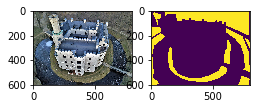

In [17]:

# Training dataset
dataset_train = TrainDataset("train")
dataset_train.prepare()

# Validation dataset
dataset_val = TrainDataset("eval")
dataset_val.prepare()

#tests
image = dataset_train.load_image(0)
mask,_ = dataset_train.load_mask(0)
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(mask[:,:,5])
print(image.shape)
print(mask.shape)



In [18]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [19]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

94658560/94653016 [==============================] - 50s 1us/step


In [20]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/duowen/cv_dataset/comp5421_TASK2/Mask_RCNN/logs/my-config20190407T0654/mask_rcnn_my-config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/home/duowen/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/duowen/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
1/1 [==============================] - 31s 31s/step - loss: 7.6556 - rpn_class_loss: 2.3407 - rpn_bbox_loss: 1.2778 - mrcnn_class_loss: 2.1586 - mrcnn_bbox_loss: 1.1229 - mrcnn_mask_loss: 0.7556 - val_loss: 7.6557 - val_rpn_class_loss: 2.3228 - val_rpn_bbox_loss: 1.5189 - val_mrcnn_class_loss: 1.8140 - val_mrcnn_bbox_loss: 1.2624 - val_mrcnn_mask_loss: 0.7377
